# Protein Family Classification — Transformer Encoder Demo

**Biological framing:** Protein families can be distinguished by sequence patterns and long-range context.

To keep this demo fast, we generate synthetic protein sequences:
- **Class A**: contains a `CXXC` pattern (Cys-any-any-Cys)
- **Class B**: contains a `GGG` pattern

### Pipeline
1. Protein strings → integer tokens → padded tensor
2. Model: Embedding + positional encoding + TransformerEncoder
3. Evaluation: accuracy + loss curve
4. Insight: self-attention mixes information across the whole sequence

Runtime target: **< 30 seconds**.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [2]:
# 1. Generate synthetic protein sequences

AA = list("ACDEFGHIKLMNPQRSTVWY")  # 20 standard amino acids


def random_protein(n, length=120):
    return ["".join(rng.choice(AA, size=length)) for _ in range(n)]


def insert_pattern(seq, pattern_type):
    if pattern_type == "CXXC":
        # Insert C??C
        i = int(rng.integers(0, len(seq) - 4))
        mid = "".join(rng.choice(AA, size=2))
        pat = "C" + mid + "C"
        return seq[:i] + pat + seq[i + 4 :]
    if pattern_type == "GGG":
        i = int(rng.integers(0, len(seq) - 3))
        return seq[:i] + "GGG" + seq[i + 3 :]
    raise ValueError("unknown pattern")


def make_dataset(n_a=600, n_b=600, length=120):
    a = [insert_pattern(s, "CXXC") for s in random_protein(n_a, length=length)]
    b = [insert_pattern(s, "GGG") for s in random_protein(n_b, length=length)]
    X = a + b
    y = np.array([0] * n_a + [1] * n_b, dtype=np.int64)  # 0=A, 1=B

    idx = rng.permutation(len(X))
    X = [X[i] for i in idx]
    y = y[idx]
    return X, y


seqs, labels = make_dataset()
print("Example A has CXXC?", "C" in seqs[np.argmin(labels)])
print("Example B has GGG?", "GGG" in seqs[np.argmax(labels)])
print("Total:", len(seqs), "Class B rate:", labels.mean().round(3))

Example A has CXXC? True
Example B has GGG? True
Total: 1200 Class B rate: 0.5


In [3]:
# 2. Tokenization: amino acids → integers, pad to same length

PAD = "_"
vocab = [PAD] + AA
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}

MAX_LEN = 120  # fixed for this demo


def tokenize(seq, max_len=MAX_LEN):
    ids = [stoi[ch] for ch in seq[:max_len]]
    if len(ids) < max_len:
        ids = ids + [stoi[PAD]] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)


class ProteinDataset(Dataset):
    def __init__(self, seqs, labels):
        self.X = np.stack([tokenize(s) for s in seqs])  # (N, L)
        self.y = labels

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx])


d = ProteinDataset(seqs[:2], labels[:2])
print(d[0][0].shape, d[0][1].item(), "vocab size:", len(vocab))

torch.Size([120]) 1 vocab size: 21


In [4]:
# 3. Train/test split + loaders

n = len(seqs)
split = int(0.8 * n)
train_seqs, test_seqs = seqs[:split], seqs[split:]
train_y, test_y = labels[:split], labels[split:]

train_ds = ProteinDataset(train_seqs, train_y)
test_ds = ProteinDataset(test_seqs, test_y)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))

Train batches: 15 Test batches: 2


In [5]:
# 4. Model: embedding + positional encoding + TransformerEncoder

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=MAX_LEN):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, L, D)

    def forward(self, x):
        # x: (B, L, D)
        return x + self.pe[:, : x.size(1), :]


class ProteinTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, num_layers=2, dim_ff=128, num_classes=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=stoi[PAD])
        self.pos = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=0.1,
            batch_first=True,
        )
        self.enc = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, ids):
        # ids: (B, L)
        x = self.embed(ids)  # (B, L, D)
        x = self.pos(x)
        x = self.enc(x)  # (B, L, D)
        x = x.mean(dim=1)  # mean pooling
        return self.head(x)  # (B, C)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProteinTransformer(vocab_size=len(vocab)).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=2e-3)

print("Device:", device)
print(model)

Device: cpu
ProteinTransformer(
  (embed): Embedding(21, 64, padding_idx=0)
  (pos): PositionalEncoding()
  (enc): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Linear(in_features=64, out_features=2, bias=True)
)


In [6]:
# 5. Training loop (few epochs)

def eval_loader(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            total_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += xb.size(0)
    return total_loss / total, correct / total


train_losses, test_losses, test_accs = [], [], []
EPOCHS = 5
for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

        running += loss.item() * xb.size(0)

    train_loss = running / len(train_ds)
    test_loss, test_acc = eval_loader(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch}/{EPOCHS} - train_loss={train_loss:.4f} test_loss={test_loss:.4f} test_acc={test_acc:.3f}")

Epoch 1/5 - train_loss=0.7322 test_loss=0.7338 test_acc=0.412


Epoch 2/5 - train_loss=0.6664 test_loss=0.6441 test_acc=0.579


Epoch 3/5 - train_loss=0.5721 test_loss=0.4438 test_acc=0.796


Epoch 4/5 - train_loss=0.5244 test_loss=0.4540 test_acc=0.829


Epoch 5/5 - train_loss=0.5232 test_loss=0.4540 test_acc=0.800


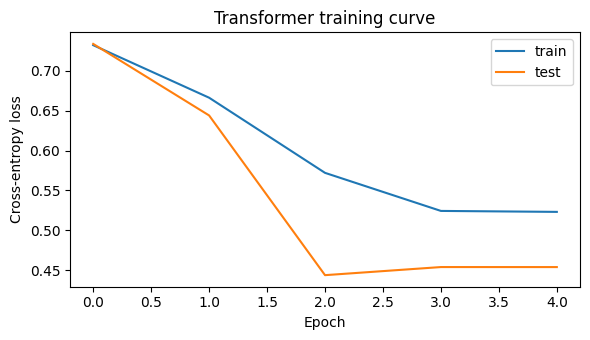

Final test accuracy: 0.8


In [7]:
# 6. Plot loss curve

plt.figure(figsize=(6, 3.5))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Transformer training curve")
plt.legend()
plt.tight_layout()
plt.show()

print("Final test accuracy:", round(test_accs[-1], 3))